<a href="https://colab.research.google.com/github/lorenzotomada/Applied_Mathematics/blob/main/Code/AM_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Equations

We want to find a root of the nonlinear function $f$ using different methods.

1. Bisection method
2. Newton method
3. Chord method
4. Secant method
5. Fixed point iterations





In [29]:
%matplotlib inline
%pylab inline
from numpy import *
from matplotlib.pyplot import *
import sympy as sym
import math

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Simpy has been imported because we will need to do some symbolic computations.
New commands are commented in the cell.

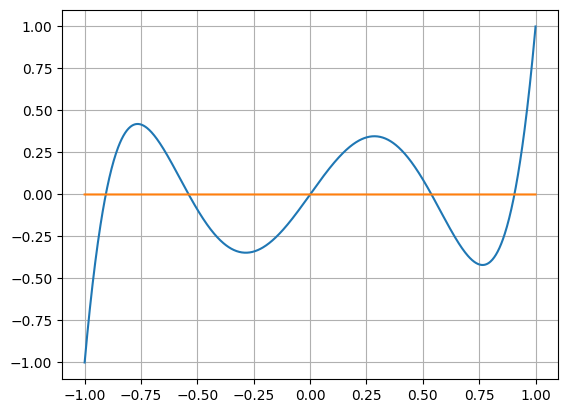

In [17]:
t = sym.symbols('t')

f_sym = t/8. * (63.*t**4 - 70.*t**2. +15.) # Legendre polynomial of order 5

f_prime_sym = sym.diff(f_sym,t)

f = sym.lambdify(t, f_sym, 'numpy')
f_prime = sym.lambdify(t,f_prime_sym, 'numpy') # To transform symbolic objects in numpy objects, on which we can operate and perform numerical computations

phi1 = lambda x : 63./70.*x**3 + 15./(70.*x)
phi2 = lambda x : 70.0/15.0*x**3 - 63.0/15.0*x**5
phi3 = lambda x : sqrt((63.*x**4 + 15.0)/70.)

# To plot:
n = 1025

x = linspace(-1,1,n)
c = zeros_like(x) # To highlight the points in which we have the roots

_ = plot(x,f(x))
_ = plot(x,c)
_ = grid()

#Initial data and stopping criteria
Let us fix the initial data for the various algorithms.

$[a, b]$ is the interval in which we seek the solution (we are interested in the biggest one). This is particularly important in the case of some methods, for example for the bisection method.

$x_0$ and ${x_{0}}_0$ are two starting points (in the following, ${x_0}_0$ is used as $x_{-1}$ for the secant method).

In [18]:
# Interval
a = 0.75
b = 1.

# Initial points
x0 = (a+b)/2.0
x00 = b

Now we define some stopping criteria.

In particular, we fix $\epsilon$ (which is the accuracy we want to reach) and $n_{max}$, the maximum number of iteration we are allowing.

In [19]:
eps = 1e-10
n_max = 1000

## Bisection method

$$
x^k = \frac{a^k+b^k}{2}
$$
```
                   if (f(a_k) * f(x_k)) < 0:
                      b_k1 = x_k
                      a_k1 = a_k
                   else:
                      a_k1 = x_k
                      b_k1 = b_k
```

Now we define a function taking as input the function $f$, points $a, b$ defining the interval, $\epsilon$ and $n_{max}$ and implementing the bisection method.

The number of iterations needed is 31
The value of the root is 0.9061798459733836
Error = 5.820766091346741e-11
CPU times: user 40.3 ms, sys: 899 µs, total: 41.2 ms
Wall time: 48.1 ms


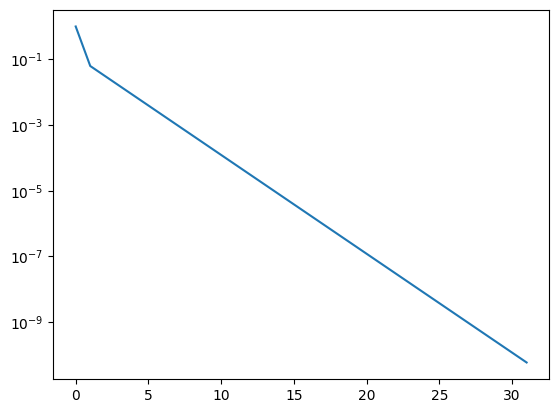

In [20]:
def bisect(f,a,b,eps,n_max):

  assert f(a)*f(b)<0
  a_new = a
  b_new = b
  x = mean([a,b])
  err = eps + 1. # So we enter in the while loop
  errors = [err] # Storing the error at each iteration. Useful to track how we get closer to the solution.
  it = 0
  while (err > eps and it < n_max):
    if ( f(a_new) * f(x) < 0 ):
      # root in (a_new,x)
      b_new = x
    else:
      # root in (x,b_new)
      a_new = x

    x_new = mean([a_new,b_new])

    # Three ways to evaluate the error:
    #err = 0.5 *(b_new -a_new) # We expect it gets close to zero as the method goes on
    #err = abs(f(x_new)) # Control on the residual
    err = abs(x-x_new) # Distance between our last approximation and the current one

    errors.append(err)
    x = x_new # Prepare for the next iteration
    it += 1 # Update the number of iterations

  semilogy(errors)
  print("The number of iterations needed is", it)
  print("The value of the root is", x)
  print('Error =', err)
  return errors

%time errors_bisect = bisect(f,a,b,eps,n_max) # writing %time gives as output the computational time as well

Is the number of iterations coherent with the theoretical estimation?
We know that in order to have $err\leq \epsilon$ we need to satisfy the condition $n\geq log_2(\frac{b-a}{\epsilon}) $

In [21]:
print(math.log2(abs((b-a)/eps)))

# Or, equivalently,
#it_theor =(log(abs(b-a))-log(eps))/log(2)
#print(it_theor)

31.219280948873624


This method is powerful because it converges globally to a solution.

However, for complex problems it might not be the best choice because of computational reasons.




-------------------------------------------------------------

In order to find out other methods for solving non-linear equations, let's compute the Taylor's series of $f(x^k)$ up to the first order

$$
f(x^k) \simeq f(x^k) + (x-x^k)f^{\prime}(x^k)
$$
which suggests the following iterative scheme
$$
x^{k+1} = x^k - \frac{f(x^k)}{f^{\prime}(x^k)}
$$

The following methods are obtained applying the above scheme where

$$
f^{\prime}(x^k) \approx q^k.
$$

These methods differ by how we define $q$ to approximate $f'(x^k)$. For instance, using Newton's method we compute the analytical expression of $f'(x^k)$.

## Newton's method
$$
q^k = f^{\prime}(x^k)
$$

$$
x^{k+1} = x^k - \frac{f(x^k)}{q^k}
$$

The number of iterations needed is 6
The value of the root is 0.906179845938664
Error = 7.771561172376096e-16
CPU times: user 34.8 ms, sys: 0 ns, total: 34.8 ms
Wall time: 44.4 ms


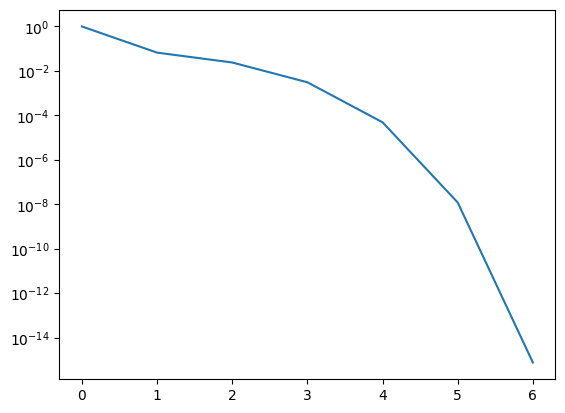

In [22]:
# Here we do not need the interval as input, but just the starting point x0!

def newton(f,f_prime,x0,eps,n_max):
  # assert abs(f_prime(x0))>1e-16 # To avoid division by zero. We could include that, if we have no additional info on f
  err = eps + 1.
  errors = [err]
  it = 0
  x=x0
  while (err > eps and it < n_max):
    q_k = f_prime(x)
    x_new = x - f(x)/q_k # This is x_{k+1}
    err = abs(x-x_new) # This is probably better for theoretical reasons, at least for Newton's method
    #err = abs(f(x_new))
    errors.append(err)
    x = x_new # Update the value of the previous iteration so we can go on correctly in the loop
    it += 1
    # We do not really need to define x as we could just update the value of x0 putting x0=x_new at the end of each step.
    # However, it would be less readable, so we decided not to do it.
  semilogy(errors)
  print("The number of iterations needed is", it)
  print("The value of the root is", x)
  print('Error =', err)
  return errors

%time errors_newton = newton(f,f_prime,1.0,eps,n_max)

## Chord method

$$
q^k \equiv q = \frac{f(b)-f(a)}{b-a}
$$

$$
x^{k+1} = x^k - \frac{f(x^k)}{q}
$$

The iterative scheme is the same, we just need to change $q_k$. Here we are being less accurate in the computation of the derivative, so we expect a lower order.

The number of iterations needed is 13
The value of the root is 0.9061798459469729
Error = 4.738154313344012e-11
CPU times: user 30.5 ms, sys: 0 ns, total: 30.5 ms
Wall time: 33.5 ms


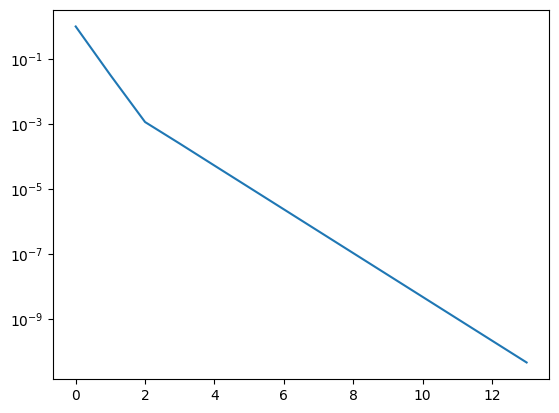

In [23]:
def chord(f,a,b,x0,eps,n_max):
  q = (f(b)-f(a))/(b-a)
  err = eps + 1
  errors = [err]
  it = 0
  x=x0
  while (err > eps and it < n_max):
    x_new = x - f(x)/q
    err = abs(x_new-x) # Distance between our last approximation and the current one
    errors.append(err)
    x = x_new
    it += 1
  semilogy(errors)
  print("The number of iterations needed is", it)
  print("The value of the root is", x)
  print('Error =', err)
  return errors

%time errors_chord = chord(f, a, b, x0, eps, n)

## Secant method

$$
q^k = \frac{f(x^k)-f(x^{k-1})}{x^k - x^{k-1}}
$$

$$
x^{k+1} = x^k - \frac{f(x^k)}{q^k}
$$

Note that this algorithm requirs **two** initial points

The number of iterations needed is 7
The value of the root is 0.9061798459386641
Error = 2.8044233602031454e-13
CPU times: user 40.2 ms, sys: 0 ns, total: 40.2 ms
Wall time: 45.5 ms


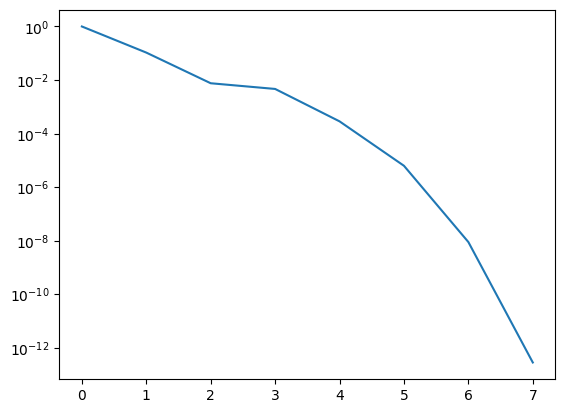

In [24]:
def secant(f,x0,x00,eps,n_max):
  x1 = x0
  x2 = x00
  err = eps + 1.
  errors = [err]
  it = 0
  while (err > eps and it < n_max):
    q_k=(f(x2)-f(x1))/(x2-x1)
    x_new = x2 - f(x2)/q_k
    err = abs(x2-x_new)
    errors.append(err)
    x1=x2
    x2 = x_new
    it += 1
    # As before for x1 and x2
  semilogy(errors)
  print("The number of iterations needed is", it)
  print("The value of the root is", x2)
  print('Error =', err)
  return errors

%time errors_secant = secant(f,x0,x00,eps,n_max)

## Fixed point iterations

$$
f(x)=0 \to x-\phi(x)=0
$$

$$
x^{k+1} = \phi(x^k)
$$

Check _AM_lab5_ for more info.

The number of iterations needed is 11
The value of the root is 0.5384693101084483
Error = 6.03431749013339e-11


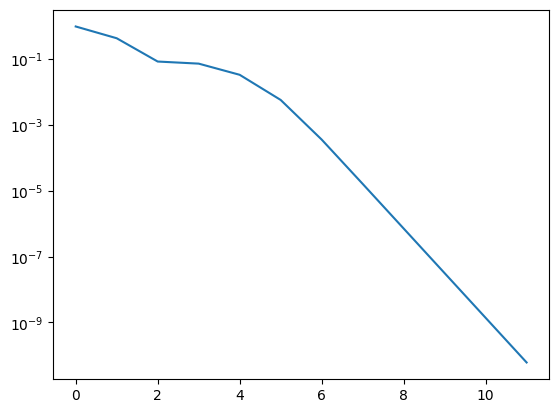

In [25]:
def fixed_point(phi1, x0, eps, n_max):
  x = x0
  err = eps + 1.
  errors = [err]
  it = 0
  while (err > eps and it < n_max):
    x_new = phi1(x)
    err = abs(x-x_new)
    errors.append(err)
    x = x_new
    it += 1
  semilogy(errors)
  print("The number of iterations needed is", it)
  print("The value of the root is", x)
  print('Error =', err)
  return errors

errors_fixed1 = fixed_point(phi1, 0.3, eps,n_max)

## Comparison
Now we plot the error convergence for the methods (in loglog scale):

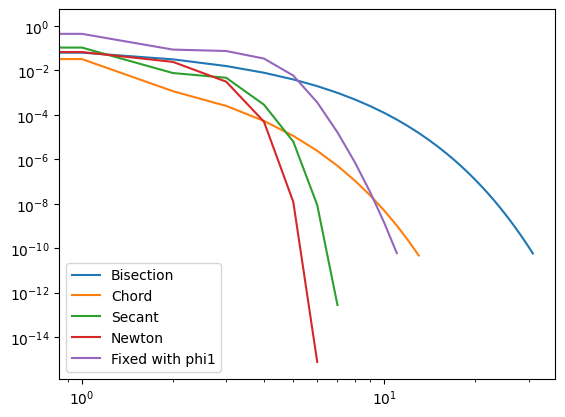

In [30]:
loglog(errors_bisect, label='Bisection')
loglog(errors_chord, label='Chord')
loglog(errors_secant, label='Secant')
loglog(errors_newton, label ='Newton')
loglog(errors_fixed1, label ='Fixed with phi1')
_ = legend()

Let us compare the SciPy implementation of Newton's method with ours:

In [28]:
import scipy.optimize as opt
%time opt.newton(f, 1.0, f_prime, tol = eps)

CPU times: user 679 µs, sys: 0 ns, total: 679 µs
Wall time: 692 µs


0.906179845938664